# Application of K-Means Clustering: Image Color Quantization

Below is an attempt in image color quantization, using a K-Means clustering algorithm written from scratch with functions from the **NumPy** library.

This notebook was part of a lab assignment submission for the course MTH00057 - Applied Maths and Statistics at VNUHCM - University of Science.

## Contents

* [Introduction](#c1)
* [Implementation](#c2)
* [Demo](#c3)
* [References](#c4)

## Introduction <a class="anchor" id="c1"></a>

Most digital image files are represented as 2-dimensional matrices of 'pixels'. Each pixel itself is an array of 3 integers ranging from 0 to 255, representing the intensity of the <font color="red"><b>R</b></font>ed, <font color="green"><b>G</b></font>reen and <font color="blue"><b>B</b></font>lue channels. 

By 'grouping' pixels that represent similar colors into `k` clusters, then recoloring each cluster with a new color that is the average RGB values of its pixels, the number of colors in an image can be effectively reduced, thus reducing the size of the image altogether while maintaining sufficient detail given the appropriate `k` value. This is one of the common applications of K-Means clustering.

An implementation of K-Means clustering can be broken down into 3 steps:
1. Select `k` intial *centroids*. In this case, the centroids can be pixels selected randomly from the input image. There also exist separate algorithms for picking the optimal starting centroids for the most efficient K-Means performance.
2. For each element in the input array, calculate the euclidean distance between it and each centroid. 'Label' the element with the centroid whose euclidean distance from it is the smallest.
3. Calculate the average value of all elements in each centroid. This average will become the new centroid.

Steps 2 and 3 are repeated until the centroids no longer change their value after being averaged. However, this can take exceedingly long for large arrays. The user can specify a certain number of iterations to prematurely stop the algorithm when they see fit.

## Implementation <a class="anchor" id="c2"></a>

The K-Means clustering algorithm in this notebook is written using only functions from the **NumPy** library. **Matplotlib** is used to visualize the output.

In [74]:
import numpy as np
import matplotlib.pyplot as plt

The algorithm will be demonstrated on an image of a colorful macaw, converted to a 2D NumPy array.

((256, 256, 3), <matplotlib.image.AxesImage at 0x1e603a2ed20>)

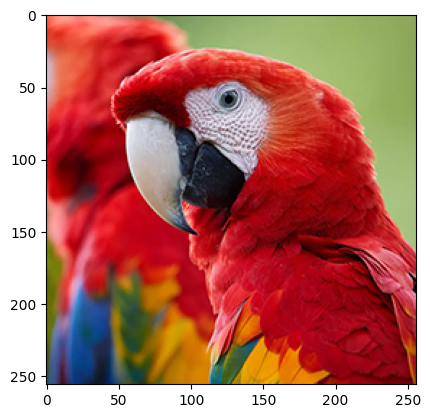

In [75]:
img = plt.imread('macaw.jpg')
orig = np.array(img)
orig.shape, plt.imshow(orig)

We need to do some preprocessing to the image array by removing the alpha channel if it exists, and flattening it into a one-dimensional array.

In [76]:
orig = orig[:,:,:3]
(h, w, c) = orig.shape
img_arr = np.array(orig).reshape(h * w, c)

img_arr

array([[254, 110,  86],
       [250, 109,  81],
       [253, 112,  85],
       ...,
       [ 94,   2,  15],
       [148,  62,  15],
       [165,  65,  13]], dtype=uint8)

The centroids are initialized by selecting random pixels from the input image. The `init_centroids_from_img` function randomly generates `k` unique integers ranging from 0 to `n`-1, `n` being the number of pixels in the input image. It then returns the elements (pixels) with the corresponding indices from the input image.

In [77]:
def init_centroids_from_img(img_1d, k_clusters):
    # replace=False to make sure the indices generated are unique
    centroid_ids = np.random.choice(img_1d.shape[0], size=k_clusters, replace=False)
    return img_1d[centroid_ids].astype('int')

Another way to intialize centroids is to directly generate `k` random 3-element arrays, making sure the value of each element is within the 0 - 256 range.

In [78]:
def init_random_centroids(img_1d, k_clusters):
    centroids = []
    for i in range(k_clusters):
        centroid = []
        for j in range(img_1d.shape[1]):
            centroid.append(np.random.randint(0, 256))
        centroids.append(centroid)
    return np.array(centroids)

Initializing 10 centroids using the first method:

In [79]:
centroids = init_centroids_from_img(img_arr, 10)
centroids

array([[218, 116,   6],
       [156, 183, 106],
       [208, 139,  10],
       [200,  27,  31],
       [217,  21,  43],
       [136,   1,  18],
       [ 85, 142, 209],
       [157,   2,   8],
       [165,  10,  28],
       [231, 128,   7]])

The centroids initialized above are stored in the `centroids` array with a unique index. *Clustering* in this sense means 'labeling' each pixel with the index of the centroid whose color it resembles the most (in other words, the euclidean distance between this pixel and the centroid it 'belongs to' is the smallest).

Calculate the euclidean distance from every centroid for each pixel, then add the index of the centroid closest to it to a `labels` array. This array can be used later to index elements from the input image thanks to **NumPy**'s powerful logical array indexing capabilities. 

The `label_pixels` function makes rather intensive use of vectorization. Further reading on K-Means optimization using vectorization is included in the [References](#c4) section.

In [80]:
def label_pixels(img_1d, centroids):
    # (n_pixels, k_clusters, distances)
    distances = np.linalg.norm(img_1d[:, None] - centroids[None], axis=2)   # distances is the axis for norm() to execute upon
    labels = np.argmin(distances, axis=1)                                   # k_clusters is the axis for argmin() to execute upon
    return labels

In [81]:
labels = label_pixels(img_arr, centroids)

labels

array([9, 9, 9, ..., 5, 8, 3], dtype=int64)

As stated above, the new centroid will be the average value of all its similarly-colored pixels. Using a boolean expression, a centroid's pixels can be filtered from the original pixel array and used to average the new value. If there exists a centroid with no labeled pixels (this can happen with randomly initialized centroids), it will be kept as is.

In [82]:
def update_centroids(img_1d, labels, old_centroids, k_clusters):
    # generate an empty centroids array
    centroids = np.empty((k_clusters, img_1d.shape[1]))
    for i in range(k_clusters):
        # filter out the pixels that were labeled with the index of the centroid
        pixels = img_1d[labels == i,:]
        # if there is no pixel filtered, the centroid remains as-is
        if pixels.size == 0:
            centroids[i,:] = old_centroids[i,:]
        else:
            # average the value of all the pixels
            centroids[i,:] = np.mean(pixels, axis=0)
    return centroids.round(0).astype('int')

In [83]:
new_centroids = update_centroids(img_arr, labels, centroids, 10)

All the functions above are brought together to build the `kmeans` function below. The function additionally takes `max_iter` (the maximum number of iterations allowed) and `init_centroids` (the centroid initialization method) as parameters, and returns the  `centroids` and `labels` arrays of the final iteration before termination.

In [84]:
def kmeans(img_1d, k_clusters, max_iter, init_centroids='random'):
    if init_centroids == 'in_pixel':
        centroids = init_centroids_from_img(img_1d, k_clusters)
    else:
        centroids = init_random_centroids(img_1d, k_clusters)

    for i in range(max_iter):
        labels = label_pixels(img_1d, centroids)
        new_centroids = update_centroids(img_1d, labels, centroids, k_clusters)
        
        # compare old and new centroids
        # if all the centroids remain the same between two consecutive iterations, the algorithm can be terminated
        if (set([tuple(centroid) for centroid in centroids]) == set([tuple(centroid) for centroid in new_centroids])):
            break
        centroids = new_centroids

    return centroids, labels

Below is a helper method to display the original image and the color-quantized image(s) side-by-side.

In [85]:
def visualize(before, after, k_clusters, mode='random'):
    if before.shape[0] >= before.shape[1]:      # height >= width
        fig = plt.figure(figsize=(7.5,5))
        cols = 3
    else:
        fig = plt.figure(figsize=(7.5,6))
        cols = 2
    rows = len(after) // cols
    # e.g.: 3 squares give 2 columns and 1 row, so there's not enough slots
    # add one row if this happens
    if len(after) % cols != 0:
        rows += 1
    # set the visual title depending on the centroid generation method
    if mode == 'in_pixel':
        plt.suptitle('Results with centroids picked from original image', fontsize=14)
    else:
        plt.suptitle('Results with randomly generated centroids', fontsize=14)
    # plot the input image
    fig.add_subplot(rows, cols, 1)
    plt.imshow(before)
    plt.title('Original image')
    # plot the outputs
    for i in range(len(after)):
        fig.add_subplot(rows, cols, i + 2)
        plt.imshow(after[i])
        plt.title('k = ' + str(k_clusters[i]))
    fig.tight_layout()

## Demo <a class="anchor" id="c3"></a>

Let's write another helper method to help run bulk quantizations for a given number of iterations and 5 values of `K`, using both centroid genration methods.

In [86]:
def bulk_exec(iters):
    k = [3, 5, 7, 16, 32]
    modes = ['random', 'in_pixel']
    for mode in modes:
        outputs = []
        for j in k:
            centroids, labels = kmeans(img_arr, j, iters)
            img_quantized = np.reshape(centroids[labels], (h, w, c))
            outputs.append(img_quantized)
        visualize(orig, outputs, k, mode)

Below are the results of an image quantized 50 times:

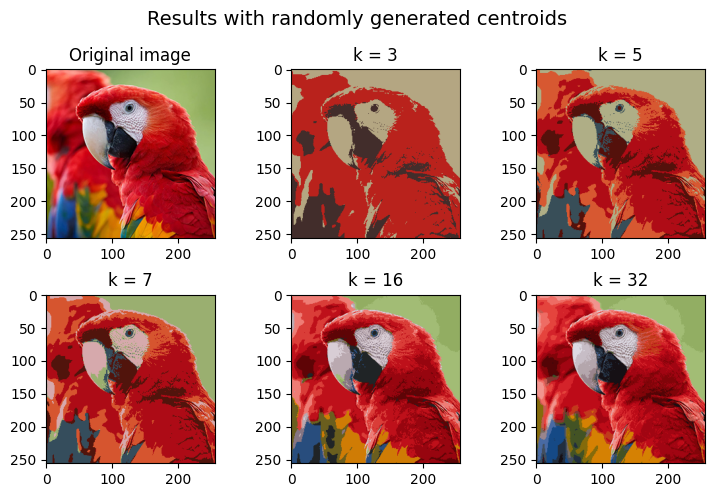

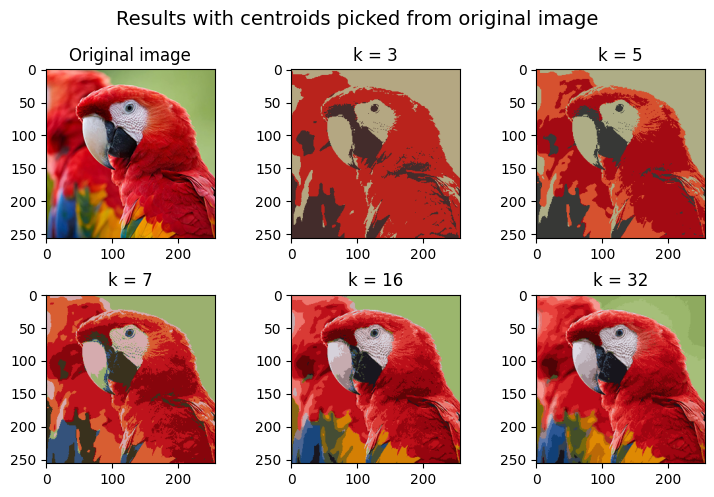

In [87]:
bulk_exec(50)

Both methods of centroid generation yields similar results, but this is due to the higher number of iterations, leading to the centroids moving around less and less after being averaged (and becoming more and more accurate in representing a distinct cluster).

The difference between the two methods are more pronounced when the image undergoes fewer quantize iterations:

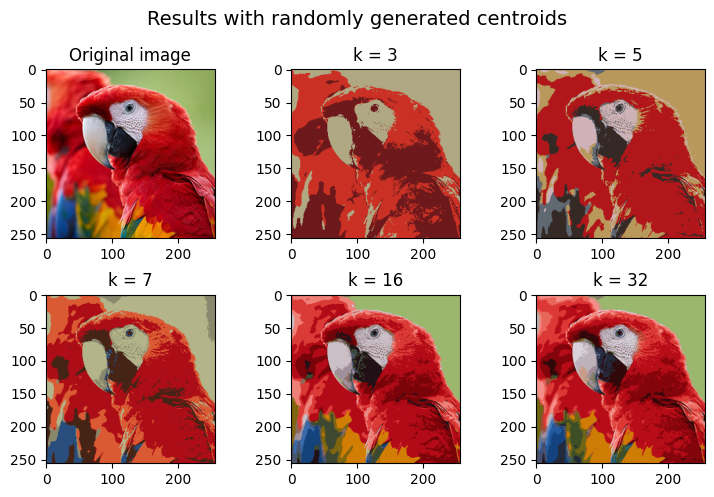

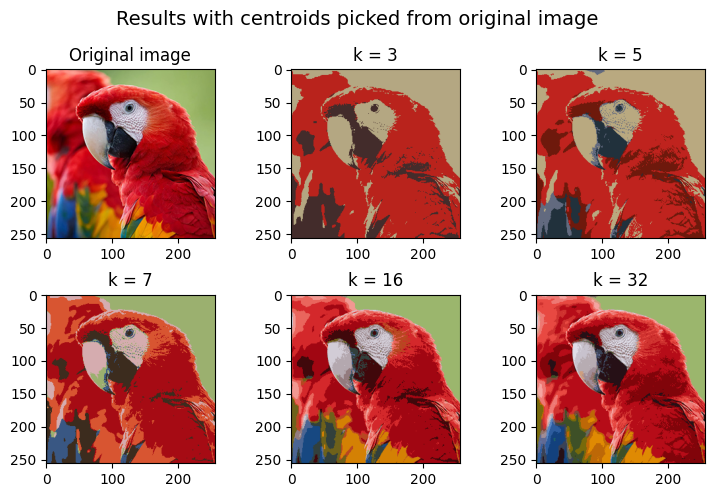

In [91]:
bulk_exec(5)

The random method yields a less correct quantization with lower `k` values, since the color values generated might not exist in the image. However, the results are more accurate the higher `k` is. Both methods also yield an image closer to the original with higher `k` values, since there are more colors to work with.

## References <a class="anchor" id="c4"></a>

1. Nguyen Hoai Nam (2021), *So tài cơ thủ với K-means Clustering*, <http://tutorials.aiclub.cs.uit.edu.vn/index.php/2021/09/08/kmeans-clustering/>

2. Bala Priya C (2022), *Learn K-Means Clustering by Quantizing Color Images in Python*, <https://hackernoon.com/learn-k-means-clustering-by-quantizing-color-images-in-python>

3. Nicholas Vadivelu (2021), *Optimizing k-Means in NumPy & SciPy*, <https://nicholasvadivelu.com/2021/05/10/fast-k-means/>

4. patildhanu4111999 n.d., *How to Display Multiple Images in One Figure Correctly in Matplotlib?*, <https://www.geeksforgeeks.org/how-to-display-multiple-images-in-one-figure-correctly-in-matplotlib/>